In [ ]:
#depth dataset1
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
img1 = cv2.imread("im0.png")
img2 = cv2.imread("im1.png")
img1 = cv2.resize(img1,(1000,700))
img2 = cv2.resize(img2,(1000,700))

k1 = np.array([[5299.313, 0, 1432.004],[0, 5299.313, 977.763],[0, 0, 1]])
k2 = np.array([[5299.313, 0, 1438.004],[0, 5299.313, 977.763],[0, 0, 1]])
baseline = 177.288
f = k1[0,0]
def normalised_mat(features):
    mean_features = np.mean(features, axis =0)
    meanx = mean_features[0]
    meany = mean_features[1]
    feature_x = features[:,0] - meanx
    feature_y = features[:,1] - meany
    s = (np.sqrt(2)/np.mean(feature_x**2 + feature_y**2))**(1/2)
    #s = 2 / (np.mean(np.sum(feature_x ** 2), (feature_y ** 2)) ** (1 /2))
    a1 = np.array([[s, 0 ,0],
                   [0, s, 0],
                   [0, 0, 1]])
    a2 = np.array([[1, 0, -(meanx)], [0, 1, -(meany)], [0, 0, 1]])
    a = a1 .dot(a2)
    ones = np.ones(len(features))
    n = np.column_stack((features,np.ones(len(features))))
    n_normalised = ((a.dot(n.T).T))
    return n_normalised , a

def normalized_fund_mat(matches,n = True):
    x1 = matches[:,0:2]
    x2 = matches[:,2:4]
    if x1.shape[0] > 7:
        if n == True:
            n1_normalised, a11 = normalised_mat(x1)
            n2_normalised, a22 = normalised_mat(x2)
        else:
            n1_normalised = x1
            n2_normalised = x2
        matrix_A = np.zeros((len(n1_normalised),9))
        for i in range(0, len(n1_normalised)):
            x1= n1_normalised[i][0]
            y1= n1_normalised[i][1]
            x2= n1_normalised[i][0]
            y2= n1_normalised[i][1]
            matrix_A[i] = np.array([x1*x2, x2*y1, x2, y2*x1, y1*y2, y2,x1, y1,1])

        U, S, V = np.linalg.svd(matrix_A)
        F_mat  = V.T[:, -1]
        F_mat  = F_mat.reshape(3,3)
        u, s, vt = np.linalg.svd(F_mat)
        s = np.diag(s)
        s[2,2] = 0
        F_mat = np.dot(u, np.dot(s, vt))
        if n:
            normalised_F = np.dot(a22.T ,np.dot(F_mat ,a11))
        return normalised_F

def errorF(features, f):
    f1 = features[0:2]
    f2 = features[2:4]
    error1 = np.array([f1[0], f1[1], 1]).T
    error2 = np.array([f2[0], f2[1], 1])
    error = np.dot(error1, np.dot(f, error2))
    abserr = np.abs(error)
    return abserr

def ransac(features):
    f_in = []
    f_best = 0
    N = 1000
    e = 0.05
    in_c = 0
    for i in range(0,N):
        ind = []
        f1 = features.shape[0]
        random_list = np.random.choice(f1, size = 8)
        feat_rand8 = features[random_list, :]
        fm = normalized_fund_mat(feat_rand8)
        for m in range(f1):
            f2 = features[m]
            err = errorF(f2, fm)
            if err < e:
                ind.append(m)
        if len(ind) > in_c:
            in_c = len(ind)
            f_best = fm
            f_in = ind
    final_features = features[f_in, :]
    return f_best, final_features
def essential_matrix(f , k1, k2):
    E = k2.T.dot(f).dot(k1)
    U,S,V = np.linalg.svd(E)
    S[0]=1
    S[1]=1
    S[2]=0
    SS = np.diag(S)
    EE = np.dot(U,np.dot(SS,V))
    return EE
def camera_pos(essen_mat):
    U_dec, S_dec, V_dec = np.linalg.svd(essen_mat)
    W= np.array([[0,-1,0],[1,0,0],[0,0,1]])
    R = []
    C = []
    c1 = U_dec[:,2]
    c2 = -U_dec[:,2]
    c3 = U_dec[:,2]
    c4 = -U_dec[:,2]
    R1 = U_dec @ W @ V_dec
    R2 = U_dec @ W @ V_dec
    R3 = U_dec @ (W.T) @ V_dec
    R4 = U_dec @ (W.T) @ V_dec
    if (np.linalg.det(R1)) < 0:
        c1 = -c1
        R1 = -R1
    if (np.linalg.det(R2)) < 0:
        c2 = -c2
        R2 = -R2
    if (np.linalg.det(R3)) <0:
        c3 = -c3
        R3 = -R3
    if (np.linalg.det(R4)) < 0:
        c4 = -c4
        R4 = -R4
    c1 = c1.reshape(3,1)
    c2 = c2.reshape(3,1)
    c3 = c3.reshape(3,1)
    c4 = c4.reshape(3,1)
    return [c1,c2,c3,c4],[R1,R2,R3,R4]

def triangulation(K1, K2, matched_pairs, R, C):
    three_D = []
    r1 = np.identity(3)
    c1 = np.zeros((3,1))
    I = np.identity(3)
    p1 = np.dot(K1, np.dot(r1, np.hstack((I, -c1.reshape(3,1)))))
    for i in range(len(C[0])):
        a1 = matched_pairs[:,0:2].T
        a2 = matched_pairs[:,2:4].T
        p2 = np.dot(K2, np.dot(R[i], np.hstack((I, -C[i].reshape(3,1)))))
        triangulate = cv2.triangulatePoints(p1, p2, a1, a2)
        three_D.append(triangulate)
    return three_D

def reprojection(pts,K,R,C):
    I = np.identity(3)
    p = np.dot(K, np.dot(R[2], np.hstack((I, -C[2].reshape(3,1)))))
    x = pts[2]
    a = np.dot(p,x)
    a = x/x[2,:]
    a = x[0, :].T
    b = x[1, :].T
    return a,b
def counts(pts3D, R, C):
    I = np.identity(3)
    p = np.dot(R, np.hstack((I, -C.reshape(3,1))))
    arr =np.array([0,0,0,1])
    p = np.vstack((p, arr.reshape(1,4)))
    n_counts = 0
    s = pts3D.shape[1]
    for i in range(s):
        a = pts3D[:,i]
        a = a.reshape(4,1)
        x = np.dot(p, x)
        x = x / x[3]
        z = x[2]
        if z > 0:
            n_counts += 1
    return n_counts
def a_value(l, y):
    a = -(l[1]*y + l[2])/l[0]
    return a
def epipolarlines(ff1,ff2,img1,img2,f,rect= False):
    epipolar_lines1 = []
    epipolar_lines2 = []
    #rect= False

    for i in range(ff1.shape[0]):
        a1 = np.array([ff1[i,0], ff1[i,1],1]).reshape(3,1)
        a2 = np.array([ff2[i,0], ff1[i,1],1]).reshape(3,1)
        lines22 = np.dot(f,a1)
        epipolar_lines2.append(lines22)
        lines11 = np.dot(f.T,a2)
        epipolar_lines1.append(lines11)
        if not rect:
            b1 = 0
            b2 = img1.shape[0]
            a1 = a_value(lines11, b1)
            a2 = a_value(lines11, b2)
            d1 = 0
            d2 = img2.shape[0]
            c1 = a_value(lines22, d1)
            c2 = a_value(lines22, d2)
        else:
            c1 = 0
            c2 = img2.shape[1] - 1
            d1 = -lines22[2]/lines22[1]
            d2 = -lines22[2]/lines22[1]
            a1 = 0
            a2 = img1.shape[1] -1
            b1 = -lines11[2]/lines11[1]
            b2 = -lines11[2]/lines11[1]
        cv2.circle(img2, (int(ff2[i,0]),int(ff2[i,1])), 3, (0,0,255), -1)
        img2 = cv2.line(img2, (int(c1), int(d1)), (int(c2), int(d2)), (255, 150, 0), 1)
        cv2.circle(img1, (int(ff1[i,0]),int(ff1[i,1])), 3, (0,0,255), -1)
        img1 = cv2.line(img1, (int(a1), int(b1)), (int(a2), int(b2)), (150, 150, 0), 1)
    img3 = np.concatenate((img2, img1), axis = 1)
    img3 = cv2.resize(img3, (1500, 660))
    #cv2.imshow("img3",img3)
    return epipolar_lines1,epipolar_lines2
def h_and_w(img):
    height, width = img.shape[:2]
    return height , width

orb = cv2.xfeatures2d.SIFT_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x :x.distance)
good = matches[0:90]
matched = []
for i,m in enumerate(good):
    feature1 = (kp1[m.queryIdx].pt)
    feature2 = (kp2[m.trainIdx].pt)
    matched.append([feature1[0], feature1[1], feature2[0], feature2[1]])
matched = np.array(matched).reshape(-1,4)
F_best, final_features = ransac(matched)
E = essential_matrix(F_best, k1, k2)
C,R = camera_pos(E)
points_three = triangulation(k1, k2, final_features, R, C)
a, b = reprojection(points_three,k2,R,C)
final_feat1 = final_features[:,0:2]
final_feat2 = final_features[:,2:4]
L1,L2 = epipolarlines(final_feat1,final_feat2,img1,img2,F_best)

height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

_, Homography1, Homography2 = cv2.stereoRectifyUncalibrated(np.float32(final_feat1), np.float32(final_feat1), F_best, imgSize=(width1, height1))
Homo_inv1 = np.linalg.inv(Homography1)
homo_invt = np.linalg.inv(Homography2.T)

#print("Homography 1 = ",Homography1)
#print("Homography 2 = ",Homography2)
best_f_Rect = np.dot(homo_invt, np.dot(F_best, Homo_inv1))

rectified1 = cv2.warpPerspective(img1, Homography1, (width1, height1))
rectified2 = cv2.warpPerspective(img2, Homography2, (width2, height2))

rectified_ff1 = cv2.perspectiveTransform(final_feat1.reshape(-1, 1, 2), Homography1).reshape(-1,2)
rectified_ff2 = cv2.perspectiveTransform(final_feat2.reshape(-1, 1, 2), Homography2).reshape(-1,2)

img1_Final = rectified1.copy()
img2_Final = rectified2.copy()
#cv2.imshow("img1_Final",img1_Final)
#cv2.imshow("img2_Final",img2_Final)
reshape1 = cv2.resize(rectified1,(int(rectified1.shape[1]/2), int(rectified1.shape[0]/2)))
reshape2 = cv2.resize(rectified2,(int(rectified2.shape[1]/2), int(rectified2.shape[0]/2)))
gray1 = cv2.cvtColor(reshape1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(reshape2,cv2.COLOR_BGR2GRAY)

win = 11
la = reshape1
ra = reshape2
la = (la).astype(int)
ra = (ra).astype(int)
las = la.shape
ras = ra.shape
if las != ras:
    print("error")
height,width,channel=la.shape
dsp_m = np.zeros((height,width))
ne_w = width - (2 * win)
la_2d = []
ra_2d = []
#print(ne_w)

for j in range(win, (height-win)):
    bl_a = []
    br_a = []
    for i in range(win, (width - win)):
        bl = la[j:j+win, i:i+win]
        br = ra[j:j+win, i:i+win]
        bl_a.append(bl.flatten())
        br_a.append(br.flatten())

    bl_a = np.array(bl_a)
    bl_a= np.repeat(bl_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = np.array(br_a)
    br_a= np.repeat(br_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = br_a.T
    difference = bl_a - br_a
    absd  = np.abs(difference)
    summ = np.sum(absd, axis = 1)
    inx = np.argmin(summ,axis = 0)
    disp = np.abs (inx - np.linspace(0, ne_w, ne_w, dtype = int)).reshape(1, ne_w)
    dsp_m[j, 0:ne_w] = disp

dsp_in = np.uint8(dsp_m * 255 / np.max(dsp_m))
#plt.imshow(dsp_in, cmap='jet', interpolation='nearest')
#plt.imshow(dsp_in, cmap= 'gray',interpolation ='nearest')
depth = (baseline * f) / (dsp_m + 1e-10)
depth[depth > 100000] = 95000
final_depth = np.uint8(depth * 255 / np.max(depth))
plt.imshow(final_depth, cmap='jet', interpolation='nearest')
cv2.waitKey(0)
cv2.destroyAllWindows()



Homography 1 =  [[-4.03939487e-03 -1.27156436e-04  2.96085645e-02]
 [ 1.43924226e-04 -3.95679998e-03 -1.24745517e-01]
 [ 5.49680783e-08  1.73187096e-09 -4.09691418e-03]]
Homography 2 =  [[ 9.92562510e-01  3.12725175e-02 -7.22663610e+00]
 [-3.63502858e-02  9.99350935e-01  1.84023158e+01]
 [-1.38830370e-05 -4.37410755e-07  1.00709461e+00]]


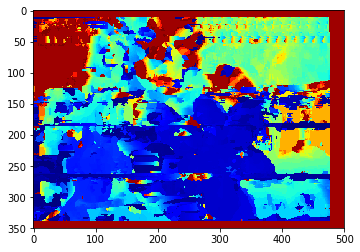

In [13]:
#disparity dataset1
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
img1 = cv2.imread("data2img1.png")
img2 = cv2.imread("data2img2.png")
img1 = cv2.resize(img1,(1000,700))
img2 = cv2.resize(img2,(1000,700))

k1 = np.array([[4396.869, 0, 1353.072], [0, 4396.869, 989.702], [0, 0, 1]])
k2 = np.array([[4396.869, 0, 1538.86], [0, 4396.869, 989.702], [0, 0, 1]])
baseline = 177.288
f = k1[0,0]

def normalised_mat(features):
    mean_features = np.mean(features, axis =0)
    meanx = mean_features[0]
    meany = mean_features[1]
    feature_x = features[:,0] - meanx
    feature_y = features[:,1] - meany
    s = (np.sqrt(2)/np.mean(feature_x**2 + feature_y**2))**(1/2)
    #s = 2 / (np.mean(np.sum(feature_x ** 2), (feature_y ** 2)) ** (1 /2))
    a1 = np.array([[s, 0 ,0],
                   [0, s, 0],
                   [0, 0, 1]])
    a2 = np.array([[1, 0, -(meanx)], [0, 1, -(meany)], [0, 0, 1]])
    a = a1 .dot(a2)
    ones = np.ones(len(features))
    n = np.column_stack((features,np.ones(len(features))))
    n_normalised = ((a.dot(n.T).T))
    return n_normalised , a

def normalized_fund_mat(matches,n = True):
    x1 = matches[:,0:2]
    x2 = matches[:,2:4]
    if x1.shape[0] > 7:
        if n == True:
            n1_normalised, a11 = normalised_mat(x1)
            n2_normalised, a22 = normalised_mat(x2)
        else:
            n1_normalised = x1
            n2_normalised = x2
        matrix_A = np.zeros((len(n1_normalised),9))
        for i in range(0, len(n1_normalised)):
            x1= n1_normalised[i][0]
            y1= n1_normalised[i][1]
            x2= n1_normalised[i][0]
            y2= n1_normalised[i][1]
            matrix_A[i] = np.array([x1*x2, x2*y1, x2, y2*x1, y1*y2, y2,x1, y1,1])

        U, S, V = np.linalg.svd(matrix_A)
        F_mat  = V.T[:, -1]
        F_mat  = F_mat.reshape(3,3)
        u, s, vt = np.linalg.svd(F_mat)
        s = np.diag(s)
        s[2,2] = 0
        F_mat = np.dot(u, np.dot(s, vt))
        if n:
            normalised_F = np.dot(a22.T ,np.dot(F_mat ,a11))
        return normalised_F

def errorF(features, f):
    f1 = features[0:2]
    f2 = features[2:4]
    error1 = np.array([f1[0], f1[1], 1]).T
    error2 = np.array([f2[0], f2[1], 1])
    error = np.dot(error1, np.dot(f, error2))
    abserr = np.abs(error)
    return abserr

def ransac(features):
    f_in = []
    f_best = 0
    N = 1000
    e = 0.05
    in_c = 0
    for i in range(0,N):
        ind = []
        f1 = features.shape[0]
        random_list = np.random.choice(f1, size = 8)
        feat_rand8 = features[random_list, :]
        fm = normalized_fund_mat(feat_rand8)
        for m in range(f1):
            f2 = features[m]
            err = errorF(f2, fm)
            if err < e:
                ind.append(m)
        if len(ind) > in_c:
            in_c = len(ind)
            f_best = fm
            f_in = ind
    final_features = features[f_in, :]
    return f_best, final_features
def essential_matrix(f , k1, k2):
    E = k2.T.dot(f).dot(k1)
    U,S,V = np.linalg.svd(E)
    S[0]=1
    S[1]=1
    S[2]=0
    SS = np.diag(S)
    EE = np.dot(U,np.dot(SS,V))
    return EE
def camera_pos(essen_mat):
    U_dec, S_dec, V_dec = np.linalg.svd(essen_mat)
    W= np.array([[0,-1,0],[1,0,0],[0,0,1]])
    R = []
    C = []
    c1 = U_dec[:,2]
    c2 = -U_dec[:,2]
    c3 = U_dec[:,2]
    c4 = -U_dec[:,2]
    R1 = U_dec @ W @ V_dec
    R2 = U_dec @ W @ V_dec
    R3 = U_dec @ (W.T) @ V_dec
    R4 = U_dec @ (W.T) @ V_dec
    if (np.linalg.det(R1)) < 0:
        c1 = -c1
        R1 = -R1
    if (np.linalg.det(R2)) < 0:
        c2 = -c2
        R2 = -R2
    if (np.linalg.det(R3)) <0:
        c3 = -c3
        R3 = -R3
    if (np.linalg.det(R4)) < 0:
        c4 = -c4
        R4 = -R4
    c1 = c1.reshape(3,1)
    c2 = c2.reshape(3,1)
    c3 = c3.reshape(3,1)
    c4 = c4.reshape(3,1)
    return [c1,c2,c3,c4],[R1,R2,R3,R4]

def triangulation(K1, K2, matched_pairs, R, C):
    three_D = []
    r1 = np.identity(3)
    c1 = np.zeros((3,1))
    I = np.identity(3)
    p1 = np.dot(K1, np.dot(r1, np.hstack((I, -c1.reshape(3,1)))))
    for i in range(len(C[0])):
        a1 = matched_pairs[:,0:2].T
        a2 = matched_pairs[:,2:4].T
        p2 = np.dot(K2, np.dot(R[i], np.hstack((I, -C[i].reshape(3,1)))))
        triangulate = cv2.triangulatePoints(p1, p2, a1, a2)
        three_D.append(triangulate)
    return three_D

def reprojection(pts,K,R,C):
    I = np.identity(3)
    p = np.dot(K, np.dot(R[2], np.hstack((I, -C[2].reshape(3,1)))))
    x = pts[2]
    a = np.dot(p,x)
    a = x/x[2,:]
    a = x[0, :].T
    b = x[1, :].T
    return a,b
def counts(pts3D, R, C):
    I = np.identity(3)
    p = np.dot(R, np.hstack((I, -C.reshape(3,1))))
    arr =np.array([0,0,0,1])
    p = np.vstack((p, arr.reshape(1,4)))
    n_counts = 0
    s = pts3D.shape[1]
    for i in range(s):
        a = pts3D[:,i]
        a = a.reshape(4,1)
        x = np.dot(p, x)
        x = x / x[3]
        z = x[2]
        if z > 0:
            n_counts += 1
    return n_counts
def a_value(l, y):
    a = -(l[1]*y + l[2])/l[0]
    return a
def epipolarlines(ff1,ff2,img1,img2,f,rect= False):
    epipolar_lines1 = []
    epipolar_lines2 = []
    #rect= False

    for i in range(ff1.shape[0]):
        a1 = np.array([ff1[i,0], ff1[i,1],1]).reshape(3,1)
        a2 = np.array([ff2[i,0], ff1[i,1],1]).reshape(3,1)
        lines22 = np.dot(f,a1)
        epipolar_lines2.append(lines22)
        lines11 = np.dot(f.T,a2)
        epipolar_lines1.append(lines11)
        if not rect:
            b1 = 0
            b2 = img1.shape[0]
            a1 = a_value(lines11, b1)
            a2 = a_value(lines11, b2)
            d1 = 0
            d2 = img2.shape[0]
            c1 = a_value(lines22, d1)
            c2 = a_value(lines22, d2)
        else:
            c1 = 0
            c2 = img2.shape[1] - 1
            d1 = -lines22[2]/lines22[1]
            d2 = -lines22[2]/lines22[1]
            a1 = 0
            a2 = img1.shape[1] -1
            b1 = -lines11[2]/lines11[1]
            b2 = -lines11[2]/lines11[1]
        cv2.circle(img2, (int(ff2[i,0]),int(ff2[i,1])), 3, (0,0,255), -1)
        img2 = cv2.line(img2, (int(c1), int(d1)), (int(c2), int(d2)), (255, 150, 0), 1)
        cv2.circle(img1, (int(ff1[i,0]),int(ff1[i,1])), 3, (0,0,255), -1)
        img1 = cv2.line(img1, (int(a1), int(b1)), (int(a2), int(b2)), (150, 150, 0), 1)
    img3 = np.concatenate((img2, img1), axis = 1)
    img3 = cv2.resize(img3, (1500, 660))
    #cv2.imshow("img3",img3)
    return epipolar_lines1,epipolar_lines2
def h_and_w(img):
    height, width = img.shape[:2]
    return height , width

orb = cv2.xfeatures2d.SIFT_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x :x.distance)
good = matches[0:90]
matched = []
for i,m in enumerate(good):
    feature1 = (kp1[m.queryIdx].pt)
    feature2 = (kp2[m.trainIdx].pt)
    matched.append([feature1[0], feature1[1], feature2[0], feature2[1]])
matched = np.array(matched).reshape(-1,4)
F_best, final_features = ransac(matched)
E = essential_matrix(F_best, k1, k2)
C,R = camera_pos(E)
points_three = triangulation(k1, k2, final_features, R, C)
a, b = reprojection(points_three,k2,R,C)
final_feat1 = final_features[:,0:2]
final_feat2 = final_features[:,2:4]
L1,L2 = epipolarlines(final_feat1,final_feat2,img1,img2,F_best)

height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

_, Homography1, Homography2 = cv2.stereoRectifyUncalibrated(np.float32(final_feat1), np.float32(final_feat1), F_best, imgSize=(width1, height1))
Homo_inv1 = np.linalg.inv(Homography1)
homo_invt = np.linalg.inv(Homography2.T)

print("Homography 1 = ",Homography1)
print("Homography 2 = ",Homography2)
best_f_Rect = np.dot(homo_invt, np.dot(F_best, Homo_inv1))

rectified1 = cv2.warpPerspective(img1, Homography1, (width1, height1))
rectified2 = cv2.warpPerspective(img2, Homography2, (width2, height2))

rectified_ff1 = cv2.perspectiveTransform(final_feat1.reshape(-1, 1, 2), Homography1).reshape(-1,2)
rectified_ff2 = cv2.perspectiveTransform(final_feat2.reshape(-1, 1, 2), Homography2).reshape(-1,2)

img1_Final = rectified1.copy()
img2_Final = rectified2.copy()
#cv2.imshow("img1_Final",img1_Final)
#cv2.imshow("img2_Final",img2_Final)
reshape1 = cv2.resize(rectified1,(int(rectified1.shape[1]/2), int(rectified1.shape[0]/2)))
reshape2 = cv2.resize(rectified2,(int(rectified2.shape[1]/2), int(rectified2.shape[0]/2)))
gray1 = cv2.cvtColor(reshape1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(reshape2,cv2.COLOR_BGR2GRAY)

win = 11
la = reshape1
ra = reshape2
la = (la).astype(int)
ra = (ra).astype(int)
las = la.shape
ras = ra.shape
if las != ras:
    print("error")
height,width,channel=la.shape
dsp_m = np.zeros((height,width))
ne_w = width - (2 * win)
la_2d = []
ra_2d = []
#print(ne_w)

for j in range(win, (height-win)):
    bl_a = []
    br_a = []
    for i in range(win, (width - win)):
        bl = la[j:j+win, i:i+win]
        br = ra[j:j+win, i:i+win]
        bl_a.append(bl.flatten())
        br_a.append(br.flatten())

    bl_a = np.array(bl_a)
    bl_a= np.repeat(bl_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = np.array(br_a)
    br_a= np.repeat(br_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = br_a.T
    difference = bl_a - br_a
    absd  = np.abs(difference)
    summ = np.sum(absd, axis = 1)
    inx = np.argmin(summ,axis = 0)
    disp = np.abs (inx - np.linspace(0, ne_w, ne_w, dtype = int)).reshape(1, ne_w)
    dsp_m[j, 0:ne_w] = disp

dsp_in = np.uint8(dsp_m * 255 / np.max(dsp_m))

#plt.imshow(dsp_in, cmap='jet', interpolation='nearest')
depth = (baseline * f) / (dsp_m + 1e-10)
depth[depth > 100000] = 95000
final_depth = np.uint8(depth * 255 / np.max(depth))
plt.imshow(final_depth, cmap='jet', interpolation='nearest')
cv2.waitKey(0)
cv2.destroyAllWindows()



In [ ]:
#disparity dataset1
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
img1 = cv2.imread("data3img1.png")
img2 = cv2.imread("data3img2.png")
img1 = cv2.resize(img1,(1000,700))
img2 = cv2.resize(img2,(1000,700))

k1 = np.array([[5806.559, 0, 1429.219], [0, 5806.559, 993.403], [0, 0, 1]])
k2 = np.array([[5806.559, 0, 1543.51], [0, 5806.559, 993.403], [0, 0, 1]])
baseline = 177.288
f = k1[0,0]

def normalised_mat(features):
    mean_features = np.mean(features, axis =0)
    meanx = mean_features[0]
    meany = mean_features[1]
    feature_x = features[:,0] - meanx
    feature_y = features[:,1] - meany
    s = (np.sqrt(2)/np.mean(feature_x**2 + feature_y**2))**(1/2)
    #s = 2 / (np.mean(np.sum(feature_x ** 2), (feature_y ** 2)) ** (1 /2))
    a1 = np.array([[s, 0 ,0],
                   [0, s, 0],
                   [0, 0, 1]])
    a2 = np.array([[1, 0, -(meanx)], [0, 1, -(meany)], [0, 0, 1]])
    a = a1 .dot(a2)
    ones = np.ones(len(features))
    n = np.column_stack((features,np.ones(len(features))))
    n_normalised = ((a.dot(n.T).T))
    return n_normalised , a

def normalized_fund_mat(matches,n = True):
    x1 = matches[:,0:2]
    x2 = matches[:,2:4]
    if x1.shape[0] > 7:
        if n == True:
            n1_normalised, a11 = normalised_mat(x1)
            n2_normalised, a22 = normalised_mat(x2)
        else:
            n1_normalised = x1
            n2_normalised = x2
        matrix_A = np.zeros((len(n1_normalised),9))
        for i in range(0, len(n1_normalised)):
            x1= n1_normalised[i][0]
            y1= n1_normalised[i][1]
            x2= n1_normalised[i][0]
            y2= n1_normalised[i][1]
            matrix_A[i] = np.array([x1*x2, x2*y1, x2, y2*x1, y1*y2, y2,x1, y1,1])

        U, S, V = np.linalg.svd(matrix_A)
        F_mat  = V.T[:, -1]
        F_mat  = F_mat.reshape(3,3)
        u, s, vt = np.linalg.svd(F_mat)
        s = np.diag(s)
        s[2,2] = 0
        F_mat = np.dot(u, np.dot(s, vt))
        if n:
            normalised_F = np.dot(a22.T ,np.dot(F_mat ,a11))
        return normalised_F

def errorF(features, f):
    f1 = features[0:2]
    f2 = features[2:4]
    error1 = np.array([f1[0], f1[1], 1]).T
    error2 = np.array([f2[0], f2[1], 1])
    error = np.dot(error1, np.dot(f, error2))
    abserr = np.abs(error)
    return abserr

def ransac(features):
    f_in = []
    f_best = 0
    N = 1000
    e = 0.05
    in_c = 0
    for i in range(0,N):
        ind = []
        f1 = features.shape[0]
        random_list = np.random.choice(f1, size = 8)
        feat_rand8 = features[random_list, :]
        fm = normalized_fund_mat(feat_rand8)
        for m in range(f1):
            f2 = features[m]
            err = errorF(f2, fm)
            if err < e:
                ind.append(m)
        if len(ind) > in_c:
            in_c = len(ind)
            f_best = fm
            f_in = ind
    final_features = features[f_in, :]
    return f_best, final_features
def essential_matrix(f , k1, k2):
    E = k2.T.dot(f).dot(k1)
    U,S,V = np.linalg.svd(E)
    S[0]=1
    S[1]=1
    S[2]=0
    SS = np.diag(S)
    EE = np.dot(U,np.dot(SS,V))
    return EE
def camera_pos(essen_mat):
    U_dec, S_dec, V_dec = np.linalg.svd(essen_mat)
    W= np.array([[0,-1,0],[1,0,0],[0,0,1]])
    R = []
    C = []
    c1 = U_dec[:,2]
    c2 = -U_dec[:,2]
    c3 = U_dec[:,2]
    c4 = -U_dec[:,2]
    R1 = U_dec @ W @ V_dec
    R2 = U_dec @ W @ V_dec
    R3 = U_dec @ (W.T) @ V_dec
    R4 = U_dec @ (W.T) @ V_dec
    if (np.linalg.det(R1)) < 0:
        c1 = -c1
        R1 = -R1
    if (np.linalg.det(R2)) < 0:
        c2 = -c2
        R2 = -R2
    if (np.linalg.det(R3)) <0:
        c3 = -c3
        R3 = -R3
    if (np.linalg.det(R4)) < 0:
        c4 = -c4
        R4 = -R4
    c1 = c1.reshape(3,1)
    c2 = c2.reshape(3,1)
    c3 = c3.reshape(3,1)
    c4 = c4.reshape(3,1)
    return [c1,c2,c3,c4],[R1,R2,R3,R4]

def triangulation(K1, K2, matched_pairs, R, C):
    three_D = []
    r1 = np.identity(3)
    c1 = np.zeros((3,1))
    I = np.identity(3)
    p1 = np.dot(K1, np.dot(r1, np.hstack((I, -c1.reshape(3,1)))))
    for i in range(len(C[0])):
        a1 = matched_pairs[:,0:2].T
        a2 = matched_pairs[:,2:4].T
        p2 = np.dot(K2, np.dot(R[i], np.hstack((I, -C[i].reshape(3,1)))))
        triangulate = cv2.triangulatePoints(p1, p2, a1, a2)
        three_D.append(triangulate)
    return three_D

def reprojection(pts,K,R,C):
    I = np.identity(3)
    p = np.dot(K, np.dot(R[2], np.hstack((I, -C[2].reshape(3,1)))))
    x = pts[2]
    a = np.dot(p,x)
    a = x/x[2,:]
    a = x[0, :].T
    b = x[1, :].T
    return a,b
def counts(pts3D, R, C):
    I = np.identity(3)
    p = np.dot(R, np.hstack((I, -C.reshape(3,1))))
    arr =np.array([0,0,0,1])
    p = np.vstack((p, arr.reshape(1,4)))
    n_counts = 0
    s = pts3D.shape[1]
    for i in range(s):
        a = pts3D[:,i]
        a = a.reshape(4,1)
        x = np.dot(p, x)
        x = x / x[3]
        z = x[2]
        if z > 0:
            n_counts += 1
    return n_counts
def a_value(l, y):
    a = -(l[1]*y + l[2])/l[0]
    return a
def epipolarlines(ff1,ff2,img1,img2,f,rect= False):
    epipolar_lines1 = []
    epipolar_lines2 = []
    #rect= False

    for i in range(ff1.shape[0]):
        a1 = np.array([ff1[i,0], ff1[i,1],1]).reshape(3,1)
        a2 = np.array([ff2[i,0], ff1[i,1],1]).reshape(3,1)
        lines22 = np.dot(f,a1)
        epipolar_lines2.append(lines22)
        lines11 = np.dot(f.T,a2)
        epipolar_lines1.append(lines11)
        if not rect:
            b1 = 0
            b2 = img1.shape[0]
            a1 = a_value(lines11, b1)
            a2 = a_value(lines11, b2)
            d1 = 0
            d2 = img2.shape[0]
            c1 = a_value(lines22, d1)
            c2 = a_value(lines22, d2)
        else:
            c1 = 0
            c2 = img2.shape[1] - 1
            d1 = -lines22[2]/lines22[1]
            d2 = -lines22[2]/lines22[1]
            a1 = 0
            a2 = img1.shape[1] -1
            b1 = -lines11[2]/lines11[1]
            b2 = -lines11[2]/lines11[1]
        cv2.circle(img2, (int(ff2[i,0]),int(ff2[i,1])), 3, (0,0,255), -1)
        img2 = cv2.line(img2, (int(c1), int(d1)), (int(c2), int(d2)), (255, 150, 0), 1)
        cv2.circle(img1, (int(ff1[i,0]),int(ff1[i,1])), 3, (0,0,255), -1)
        img1 = cv2.line(img1, (int(a1), int(b1)), (int(a2), int(b2)), (150, 150, 0), 1)
    img3 = np.concatenate((img2, img1), axis = 1)
    img3 = cv2.resize(img3, (1500, 660))
    #cv2.imshow("img3",img3)
    return epipolar_lines1,epipolar_lines2
def h_and_w(img):
    height, width = img.shape[:2]
    return height , width

orb = cv2.xfeatures2d.SIFT_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x :x.distance)
good = matches[0:90]
matched = []
for i,m in enumerate(good):
    feature1 = (kp1[m.queryIdx].pt)
    feature2 = (kp2[m.trainIdx].pt)
    matched.append([feature1[0], feature1[1], feature2[0], feature2[1]])
matched = np.array(matched).reshape(-1,4)
F_best, final_features = ransac(matched)
E = essential_matrix(F_best, k1, k2)
C,R = camera_pos(E)
points_three = triangulation(k1, k2, final_features, R, C)
a, b = reprojection(points_three,k2,R,C)
final_feat1 = final_features[:,0:2]
final_feat2 = final_features[:,2:4]
L1,L2 = epipolarlines(final_feat1,final_feat2,img1,img2,F_best)

height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

_, Homography1, Homography2 = cv2.stereoRectifyUncalibrated(np.float32(final_feat1), np.float32(final_feat1), F_best, imgSize=(width1, height1))
Homo_inv1 = np.linalg.inv(Homography1)
homo_invt = np.linalg.inv(Homography2.T)

print("Homography 1 = ",Homography1)
print("Homography 2 = ",Homography2)
best_f_Rect = np.dot(homo_invt, np.dot(F_best, Homo_inv1))

rectified1 = cv2.warpPerspective(img1, Homography1, (width1, height1))
rectified2 = cv2.warpPerspective(img2, Homography2, (width2, height2))

rectified_ff1 = cv2.perspectiveTransform(final_feat1.reshape(-1, 1, 2), Homography1).reshape(-1,2)
rectified_ff2 = cv2.perspectiveTransform(final_feat2.reshape(-1, 1, 2), Homography2).reshape(-1,2)

img1_Final = rectified1.copy()
img2_Final = rectified2.copy()
#cv2.imshow("img1_Final",img1_Final)
#cv2.imshow("img2_Final",img2_Final)
reshape1 = cv2.resize(rectified1,(int(rectified1.shape[1]/2), int(rectified1.shape[0]/2)))
reshape2 = cv2.resize(rectified2,(int(rectified2.shape[1]/2), int(rectified2.shape[0]/2)))
gray1 = cv2.cvtColor(reshape1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(reshape2,cv2.COLOR_BGR2GRAY)

win = 11
la = reshape1
ra = reshape2
la = (la).astype(int)
ra = (ra).astype(int)
las = la.shape
ras = ra.shape
if las != ras:
    print("error")
height,width,channel=la.shape
dsp_m = np.zeros((height,width))
ne_w = width - (2 * win)
la_2d = []
ra_2d = []
#print(ne_w)

for j in range(win, (height-win)):
    bl_a = []
    br_a = []
    for i in range(win, (width - win)):
        bl = la[j:j+win, i:i+win]
        br = ra[j:j+win, i:i+win]
        bl_a.append(bl.flatten())
        br_a.append(br.flatten())

    bl_a = np.array(bl_a)
    bl_a= np.repeat(bl_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = np.array(br_a)
    br_a= np.repeat(br_a[:,:,np.newaxis],ne_w, axis = 2)
    br_a = br_a.T
    difference = bl_a - br_a
    absd  = np.abs(difference)
    summ = np.sum(absd, axis = 1)
    inx = np.argmin(summ,axis = 0)
    disp = np.abs (inx - np.linspace(0, ne_w, ne_w, dtype = int)).reshape(1, ne_w)
    dsp_m[j, 0:ne_w] = disp

dsp_in = np.uint8(dsp_m * 255 / np.max(dsp_m))
#plt.imshow(dsp_in, cmap='hot', interpolation='nearest')
depth = (baseline * f) / (dsp_m + 1e-10)
depth[depth > 100000] = 95000
final_depth = np.uint8(depth * 255 / np.max(depth))
plt.imshow(final_depth, cmap='jet', interpolation='nearest')
cv2.waitKey(0)
cv2.destroyAllWindows()


